In [1]:
import os

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt, image as mpimg
import argparse
import imutils
import math

from KartriderKit.Vision.Utils import *
WORKPATH = "D:/GameProjects/Kartrider/SmartKartRider"
RAW_DATA_PATH = WORKPATH + "/raw_data/US"
%matplotlib inline

In [2]:
# def process_image(image):
#     global first_frame
#
#     gray_image = grayscale(image)
#     plt.imshow(gray_image, cmap="gray")
#     mask_white = cv2.inRange(gray_image*255, 200, 240)
#     kernel = np.ones((2, 2), np.uint8) #腐蚀
#     mask_white = cv2.erode(mask_white, kernel, iterations=1)
#     kernel_size = 5
#     gauss_gray = gaussian_blur(mask_white,kernel_size)
#
#     low_threshold = 50
#     high_threshold = 150
#     canny_edges = canny(gauss_gray,low_threshold,high_threshold)
#
#     rho = 4
#     theta = np.pi/180
#     threshold = 30
#     min_line_len = 100
#     max_line_gap = 180
#
#     line_image = hough_lines(canny_edges, rho, theta, threshold, min_line_len, max_line_gap)
#     result = weighted_img(line_image, (image*255).astype("uint8"), α=0.8, β=1., λ=0.)
#     plt.imshow(result, cmap = "gray")
#
#     return result
#
# for source_img in os.listdir(WORKPATH + "/raw_data/US/SmallMap/"):
#     first_frame = 1
#     image = mpimg.imread(WORKPATH + "./raw_data/US/SmallMap/"+source_img)
#     print(source_img)
#     processed = process_image(image)
#     mpimg.imsave(WORKPATH + "/raw_data/US/SmallMap/annotated_"+source_img,processed)

In [ ]:
image = mpimg.imread(WORKPATH + "./raw_data/US/SmallMap/0.png")
image = image[0:int(image.shape[0]/1.5),:]
plt.imshow(image)

In [43]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convert to grayscale
    # gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv.Sobel(img, cv.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv.Sobel(img, cv.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

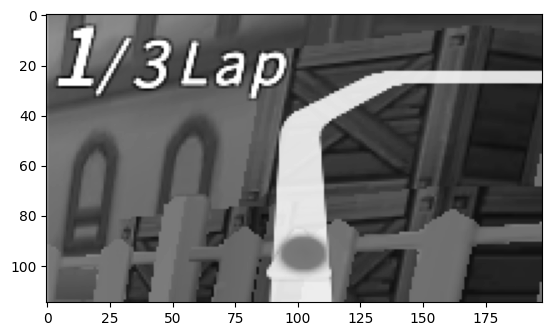

In [20]:
gray_image = grayscale(image)
plt.imshow(gray_image, cmap="gray")

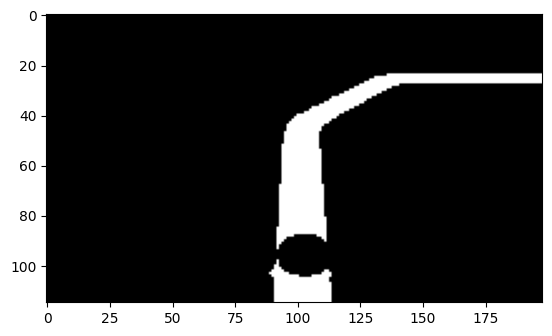

In [21]:
mask_white = cv2.inRange(gray_image*255, 200, 240)
kernel = np.ones((2, 2), np.uint8) #腐蚀
mask_white = cv2.erode(mask_white, kernel, iterations=1)
# plt.imshow(cv2.cvtColor(mask_white, cv2.COLOR_BGR2RGB))
plt.imshow(mask_white, cmap="gray")

In [35]:
# h, w, c = image.shape
# h, w, c

198 115


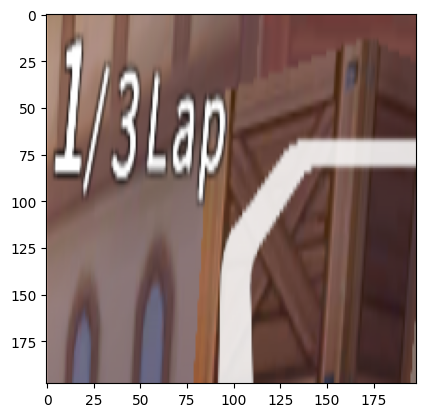

In [45]:
def warp_image(img):

    image_size = (img.shape[1], img.shape[0])
    # x = img.shape[1]
    # y = img.shape[0]
    h, w, c = img.shape

    #the "order" of points in the polygon you are defining does not matter
    #but they need to match the corresponding points in destination_points!
    # source_points = np.float32([
    # [0.117 * x, y],
    # [(0.5 * x) - (x*0.078), (2/3)*y],
    # [(0.5 * x) + (x*0.078), (2/3)*y],
    # [x - (0.117 * x), y]
    # ])
    source_points = np.array([[0,0],[0,h],[w,0],[w,h]], np.float32)

#     #chicago footage
#     source_points = np.float32([
#                 [300, 720],
#                 [500, 600],
#                 [700, 600],
#                 [850, 720]
#                 ])

#     destination_points = np.float32([
#                 [200, 720],
#                 [200, 200],
#                 [1000, 200],
#                 [1000, 720]
#                 ])

    # destination_points = np.float32([
    # [0.25 * x, y],
    # [0.25 * x, 0],
    # [x - (0.25 * x), 0],
    # [x - (0.25 * x), y]
    # ])
    destination_points = np.array([[0,0], [0,198], [198,0], [198,198]], np.float32)


    perspective_transform = cv.getPerspectiveTransform(source_points, destination_points)
    inverse_perspective_transform = cv.getPerspectiveTransform( destination_points, source_points)

    warped_img = cv.warpPerspective(img, perspective_transform, image_size, flags=cv.INTER_LINEAR)

    #print(source_points)
    #print(destination_points)
    # warped_img = warped_img
    warped_img = cv2.resize(warped_img, (w,w))
    print(w,h)
    return warped_img, inverse_perspective_transform
birdseye_result, inverse_perspective_transform = warp_image(image)
plt.imshow(birdseye_result, cmap="gray")

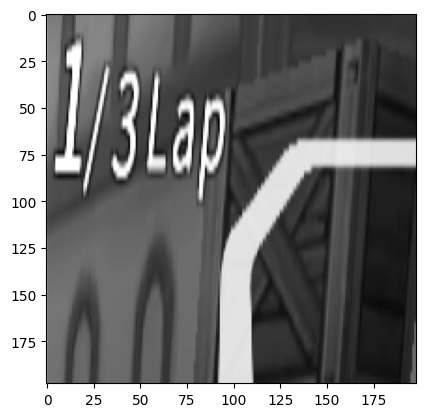

In [46]:
gray_image = grayscale(birdseye_result)
plt.imshow(gray_image, cmap="gray")

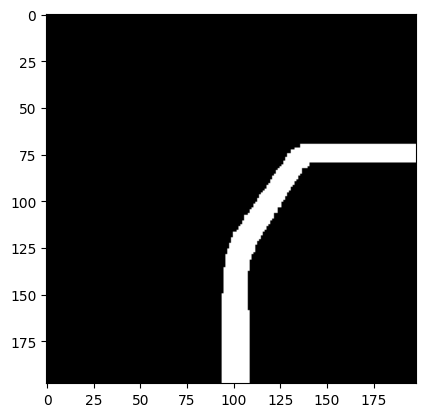

In [47]:
mask_white = cv2.inRange(gray_image*255, 200, 240)
kernel = np.ones((3, 3), np.uint8) #腐蚀
mask_white = cv2.erode(mask_white, kernel, iterations=1)
# plt.imshow(cv2.cvtColor(mask_white, cv2.COLOR_BGR2RGB))

plt.imshow(mask_white, cmap="gray")

In [50]:
def track_lanes_initialize(binary_warped):

    global window_search

    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # we need max for each half of the histogram. the example above shows how
    # things could be complicated if didn't split the image in half
    # before taking the top 2 maxes
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    # this will throw an error in the height if it doesn't evenly divide the img height
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3)
        cv.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit

def track_lanes_update(binary_warped, left_fit,right_fit):

    global window_search
    global frame_count

    # repeat window search to maintain stability
    if frame_count % 10 == 0:
        window_search=True


    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    return left_fit,right_fit,leftx,lefty,rightx,righty

left_fit,right_fit = track_lanes_initialize(mask_white)
global frame_count
frame_count=0
left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye_result, left_fit,right_fit)

C:\Users\Johan\AppData\Local\Temp\ipykernel_29620\2824865554.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\Johan\AppData\Local\Temp\ipykernel_29620\2824865554.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the releas

no lane detected


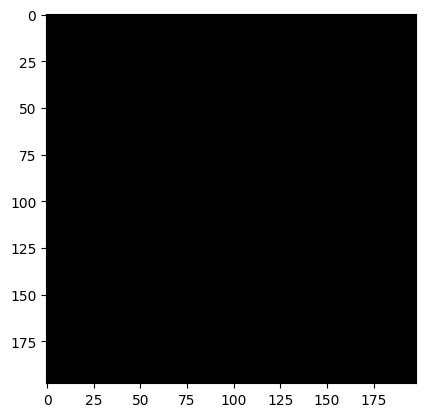

In [35]:
kernel_size = 5
gauss_gray = gaussian_blur(mask_white,kernel_size)
# gauss_gray = gaussian_blur(mask_yw_image,kernel_size)

#same as quiz values
low_threshold = 50
high_threshold = 150
canny_edges = canny(gauss_gray,low_threshold,high_threshold)

# imshape = image.shape
# lower_left = [imshape[1]/9,imshape[0]/2]
# lower_right = [imshape[1]-imshape[1]/9,imshape[0]/2]
# lower_left = [imshape[1],imshape[0]]
# lower_right = [imshape[1],imshape[0]]
# top_left = [imshape[1]/2-imshape[1]/8,imshape[0]/5]
# top_right = [imshape[1]/2+imshape[1]/8,imshape[0]/5]
# top_left = [imshape[1]/2-imshape[1]/8,imshape[0]/2+imshape[0]/10]
# top_right = [imshape[1]/2+imshape[1]/8,imshape[0]/2+imshape[0]/10]


# vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)]
# roi_image = region_of_interest(canny_edges, vertices)

#rho and theta are the distance and angular resolution of the grid in Hough space
#same values as quiz
rho = 4
# rho = 4
theta = np.pi/180
#threshold is minimum number of intersections in a grid for candidate line to go to output
threshold = 30
# threshold = 30
# min_line_len = 100
# min_line_len = 100
min_line_len = 100
max_line_gap = 180
#my hough values started closer to the values in the quiz, but got bumped up considerably for the challenge video

# line_image = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap)
line_image = hough_lines(canny_edges, rho, theta, threshold, min_line_len, max_line_gap)
# result = weighted_img(line_image, (image*255).astype("uint8"), α=0.8, β=1., λ=0.)
plt.imshow(line_image, cmap = "gray")
# plt.imshow(result, cmap = "gray")

In [51]:
plt.imshow(gauss_gray, cmap = "gray")

NameError: name 'gauss_gray' is not defined

In [52]:
for min_line_len in range(200):
    for max_line_gap in range(200):
        for threshold in range(100):
            try:
                line_image = hough_lines(canny_edges, rho, theta, threshold, min_line_len, max_line_gap)
                plt.imshow(line_image, cmap = "gray")
            except:
                continue

In [ ]:
line_image

no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
no lane detected
